In [147]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import FinanceDataReader as fdr #pip3 install --user finance-datareader
from fredapi import Fred
import datetime, os


In [148]:
#ticker='msft aapl goog'#'SPY'
tickers=['QQQ','GLD']
yf.pdr_override()
df_price = pdr.get_data_yahoo(tickers)
df_price.isnull().sum()
df_price.dropna(axis=0,inplace=True)

[*********************100%***********************]  2 of 2 completed


In [149]:
start = df_price.index[0] 
end   = df_price.index[-1]
df_new_index = pd.date_range(start,end)
df_price = df_price.reindex(df_new_index)

df_price.isna().sum()
df_price.replace(np.NaN, 0, inplace=True)
df_price[0:10]

Adj Close                 Close                  High             \
                  GLD        QQQ        GLD        QQQ        GLD        QQQ   
2004-11-18  44.380001  34.003864  44.380001  39.290001  44.490002  39.360001   
2004-11-19  44.779999  33.475941  44.779999  38.680000  44.919998  39.290001   
2004-11-20   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
2004-11-21   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
2004-11-22  44.950001  33.796150  44.950001  39.049999  44.970001  39.070000   
2004-11-23  44.750000  33.744236  44.750000  38.990002  44.919998  39.150002   
2004-11-24  45.049999  34.038486  45.049999  39.330002  45.049999  39.389999   
2004-11-25   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
2004-11-26  45.290001  33.934643  45.290001  39.209999  45.599998  39.480000   
2004-11-27   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   

                  Low                  Open                 Volume  \
                  GLD        QQQ        GLD        QQQ         GLD   
2004-11-18  44.070000  38.889999  44.430000  38.980000   5992000.0   
2004-11-19  44.470001  38.590000  44.490002  39.240002  11655300.0   
2004-11-20   0.000000   0.000000   0.000000   0.000000         0.0   
2004-11-21   0.000000   0.000000   0.000000   0.000000         0.0   
2004-11-22  44.740002  38.480000  44.750000  38.610001  11996000.0   
2004-11-23  44.720001  38.610001  44.880001  39.009998   3169200.0   
2004-11-24  44.790001  39.070000  44.930000  39.090000   6105100.0   
2004-11-25   0.000000   0.000000   0.000000   0.000000         0.0   
2004-11-26  45.060001  39.169998  45.250000  39.369999   3097700.0   
2004-11-27   0.000000   0.000000   0.000000   0.000000         0.0   

                         
                    QQQ  
2004-11-18   94901100.0  
2004-11-19  118448900.0  
2004-11-20          0.0  
2004-11-21          0.0  
2004-11-22   79882600.0  
2004-11-23   91925300.0  
2004-11-24   74051700.0  
2004-11-25          0.0  
2004-11-26   31248900.0  
2004-11-27          0.0

In [150]:
for today in df_price.index[1:]:
  for col in df_price.columns.values:
    if df_price[col][today] == 0:
      df_price[col][today] = df_price[col][today-datetime.timedelta(days=1)]

In [151]:
trading_df = pd.DataFrame(df_price['Close'])

etfs = np.array(trading_df.columns.values)[::-1]

trading_df[[etf+'_qty' for etf in etfs]]     = 0
trading_df[[etf+'_capital' for etf in etfs]] = 0
trading_df['Total'] = 0
trading_df[0:10]

,GLD,QQQ,QQQ_qty,GLD_qty,QQQ_capital,GLD_capital,Total
2004-11-18,44.380001,39.290001,0,0,0,0,0
2004-11-19,44.779999,38.680000,0,0,0,0,0
2004-11-20,44.779999,38.680000,0,0,0,0,0
2004-11-21,44.779999,38.680000,0,0,0,0,0
2004-11-22,44.950001,39.049999,0,0,0,0,0
2004-11-23,44.750000,38.990002,0,0,0,0,0
2004-11-24,45.049999,39.330002,0,0,0,0,0
2004-11-25,45.049999,39.330002,0,0,0,0,0
2004-11-26,45.290001,39.209999,0,0,0,0,0
2004-11-27,45.290001,39.209999,0,0,0,0,0


In [152]:
import datetime
from dateutil import relativedelta

def get_pivot(year, month, day):
  pivot_date = datetime.datetime.strptime("%d-%d-%d"%(year,month,day), "%Y-%m-%d")
  return pivot_date

def get_next_month(today:datetime):
    nextmonth = today + relativedelta.relativedelta(months=1)
    return nextmonth

def set_reblancing_date(trading_df, start_date, end_date):
  trading_df['Pivot'] = 0
  trading_df.loc[start_date,'Pivot'] = 1
  trading_df.loc[end_date,'Pivot'] = 1
  iter_date = start_date
  while iter_date < end_date:
    AW_4_  = (iter_date.month==4)
    AW_11_ = (iter_date.month==11)
    if (AW_4_ or AW_11_):
      pivot_date = get_pivot(iter_date.year,iter_date.month,28)
      trading_df.loc[pivot_date,'Pivot'] = 1 
    iter_date = get_next_month(iter_date)
  return trading_df

In [153]:
# Sim Env
start_date = datetime.datetime.strptime('2010-01-03', '%Y-%m-%d')
end_date   = datetime.datetime.strptime('2022-03-30', '%Y-%m-%d')
period = (start_date <= trading_df.index) & (end_date >= trading_df.index)
trading_df = trading_df.loc[period]

init_capital = 1_000_000

trading_df = set_reblancing_date(trading_df,start_date, end_date)


In [154]:
REBLANCING = 1
def buy_portpolio(trading_df, init_capital ,etfs):
  capital = init_capital
  ratios = [0.5, 0.5] 
  budgets = (np.ones(len(etfs))*capital)*ratios
  qtys   = (budgets/ trading_df.loc[trading_df.index[0],etfs].values).astype(int)

  for i, etf in enumerate(etfs):
    trading_df.loc[:, etf+'_qty'] = qtys[i] 
    trading_df[etf+'_capital'] = trading_df[etf+'_qty']*trading_df[etf]
  
  if REBLANCING:
    trading_df['Total'] = trading_df[[etf+'_capital' for etf in etfs]].sum(axis=1)
  trading_df['Yield'] = (trading_df['Total']-capital)/capital*100
  trading_df['MDD'] = 0
  return trading_df

trading_df = buy_portpolio(trading_df, init_capital, etfs)
not_reblance = trading_df.copy()
#trading_df[['QQQ_capital', 'GLD_capital']].plot()
#trading_df['Total'].plot()

<AxesSubplot:>

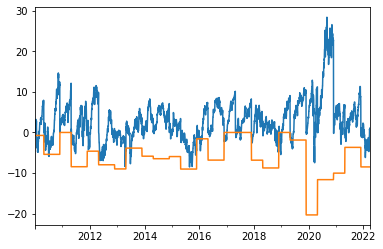

In [155]:
# Reblancing
index = trading_df.loc[trading_df['Pivot']==True,:].index.values
#print(index)

for i in range(len(index)-1):
  period = (index[i] <= trading_df.index) & (index[i+1] >= trading_df.index)
  quater_df = trading_df.loc[period,:].copy()
  
  quater_capital = 0
  for etf in etfs:
    quater_capital = quater_capital + quater_df.iloc[0].xs(etf+'_capital')
  quater_df = buy_portpolio(quater_df, quater_capital, etfs)

  # MDD
  maximum = quater_df['Yield'][quater_df['Yield'].idxmax()]
  minimum = quater_df['Yield'].loc[  (quater_df['Yield'].idxmax()<=quater_df.index)].min()
  quater_df['MDD'] = minimum-maximum
  trading_df.loc[period,:] = quater_df

#trading_df[['QQQ_capital', 'GLD_capital']].plot()
trading_df['Yield'].plot()
trading_df['MDD'].plot()

<AxesSubplot:>

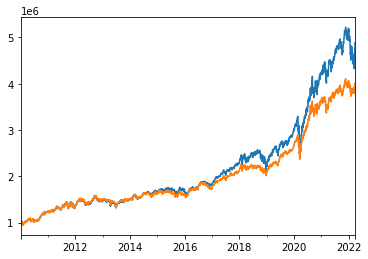

In [156]:
#trading_df[['QQQ_capital', 'GLD_capital']].plot()
not_reblance['Total'].plot()
trading_df['Total'].plot()